In [1]:
from scipy.io import wavfile
from scipy import signal
import re
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

# Import dataset

In [2]:
DATADIR = 'dataset'  # unzipped train and test data
ALL_LABELS = ('bed bird cat dog down eight five four go ' +
                   'happy house left marvin name.txt nine no ' +
                   'off on one right seven sheila six stop three ' +
                   'tree two up wow yes zero silence').split()

In [3]:
num_labels = len(ALL_LABELS)
id2name = {i: name for i, name in enumerate(ALL_LABELS)}
name2id = {name: i for i, name in id2name.items()}

In [4]:
p_validation_list = Path(DATADIR).joinpath('train/validation_list.txt')

In [5]:
p_validation_list

WindowsPath('dataset/train/validation_list.txt')

In [6]:
def load_data(data_dir):
    DATADIR = 'dataset'  # unzipped train and test data
    ALL_LABELS = ('bed bird cat dog down eight five four go ' +
                   'happy house left marvin name.txt nine no ' +
                   'off on one right seven sheila six stop three ' +
                   'tree two up wow yes zero silence').split()
    num_labels = len(ALL_LABELS)
    id2name = {i: name for i, name in enumerate(ALL_LABELS)}
    name2id = {name: i for i, name in id2name.items()}
    pattern = re.compile("(.+\\\\)?(\w+)\\\\([^_]+)_.+wav")
    pattern_v = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    
    all_files = glob(os.path.join(data_dir, 'train\\audio\\*\\*wav'))

    with open(os.path.join(data_dir, 'train\\validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern_v, entry)
        if r:
            valset.add(r.group(3))

    possible = set(ALL_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    return train, val

train, val = load_data(DATADIR)

There are 57929 train and 6798 val samples


# MFCC

In [7]:
import numpy as np
from scipy.io import wavfile
import python_speech_features

def mfcc(audio, sample_rate, **kwargs):
    """从读出的音频数据中算出mfcc,具体可以看python_speech_features的文档

    Parameters:
        audio (np.ndarray): - 指明音频的振幅序列
        sample_rate (int): - 指明抽样率
        numcep (int): - 指明返回的倒数数量,默认为13

    Returns:
        np.ndarray: - mfcc强度(二维)组成的元组,shape为(times.shape,numcep)
    """
    return python_speech_features.mfcc(audio, sample_rate, **kwargs)


def mfcc_from_path(record_path, **kwargs):
    """从音频文件读取出mfcc

    Parameters:
        record_path (Union[pathlib.Path,str]): - 指明音频的路径

    Returns:
        np.ndarray: - mfcc强度(二维)组成的元组,shape为(times.shape,numcep)
    """
    sample_rate, samples = wavfile.read(str(record_path))
    return mfcc(samples, sample_rate,**kwargs)

# Load Transformed Train Data

In [8]:
from keras.utils import to_categorical

train = np.array(train)
np.random.shuffle(train)
train = train.tolist()

size = len(train)

trainX = np.zeros( (len(train),99,13) )
trainY = []

for i, (label_id,uid,fname) in enumerate(train):
    try:
        x = mfcc_from_path(fname).tolist()
        # ---------------------------------------
        # Preprocess the train input sequence
        # - Padding 0.0 at the end if length < 99
        # - If longer than 99, choose only the first 99 items
        # ---------------------------------------
        while len(x) < 99:
            x.append([0.0]*13)
        if len(x) > 99:
            x = x[0:99]
        trainX[i] = x
        trainY.append(label_id)
        if i % 2000 == 0:
            print("Loading {}/{}.".format(i, size))
    except Exception as err:
        print(err)
        
print("Finish loading train data")
trainY = to_categorical(trainY, num_classes=num_labels)

print("Input Shape: ",  trainX.shape)
print("Output Shape: ", trainY.shape)

Using TensorFlow backend.


Loading 0/57929.


C:\Users\Administrator\Anaconda3\envs\py3.5\lib\site-packages\scipy\io\wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Loading 2000/57929.
Loading 4000/57929.
Loading 6000/57929.
Loading 8000/57929.
Loading 10000/57929.
Loading 12000/57929.
Loading 14000/57929.
Loading 16000/57929.
Loading 18000/57929.
Loading 20000/57929.
Loading 22000/57929.
Loading 24000/57929.
Loading 26000/57929.
Loading 28000/57929.
Loading 30000/57929.
Loading 32000/57929.
Loading 34000/57929.
Loading 36000/57929.
Loading 38000/57929.
Loading 40000/57929.
Loading 42000/57929.
Loading 44000/57929.
Loading 46000/57929.
Loading 48000/57929.
Loading 50000/57929.
Loading 52000/57929.
Loading 54000/57929.
Loading 56000/57929.
Finish loading train data
Input Shape:  (57929, 99, 13)
Output Shape:  (57929, 32)


# Load Validation Data

In [9]:
valX = np.zeros( (len(val),99,13) )
valY = []

size = len(val)

for i, (label_id,uid,fname) in enumerate(val):
    try:
        x = mfcc_from_path(fname).tolist()
        # ---------------------------------------
        # Preprocess the train input sequence
        # - Padding 0.0 at the end if length < 99
        # - If longer than 99, choose only the first 99 items
        # ---------------------------------------
        while len(x) < 99:
            x.append([0.0]*13)
        if len(x) > 99:
            x = x[0:99]
        valX[i] = x
        valY.append(label_id)
        if i % 2000 == 0:
            print("Loading {}/{}.".format(i, size))
    except Exception as err:
        print(err)
        
print("Finish loading val data.")
valY = to_categorical(valY, num_classes=num_labels)

print("Input Shape: ",  valX.shape)
print("Output Shape: ", valY.shape)

Loading 0/6798.
Loading 2000/6798.
Loading 4000/6798.
Loading 6000/6798.
Finish loading val data.
Input Shape:  (6798, 99, 13)
Output Shape:  (6798, 32)


# Build the model

In [10]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, GlobalAveragePooling1D, AveragePooling1D, Activation
from keras.utils import to_categorical

from keras.layers import merge
from keras.layers.core import *
from keras.models import *

In [16]:
max_len = 99
embed_dim = 13

MODEL_TYPE = "lstm"
ATTENTION = True
LEARN_RATE = 0.001
BATCH_SIZE = 20
INPUT_SHAPE = [max_len, embed_dim]
EPOCHE = 8#15
NUM_HIDDEN = 100
TIME_STEPS = max_len
SINGLE_ATTENTION_VECTOR = False

In [17]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

inputs = Input(shape=(INPUT_SHAPE))
# RNN Layer
if MODEL_TYPE == 'rnn':
    rnn_out = SimpleRNN(NUM_HIDDEN, return_sequences=True)(inputs)
elif MODEL_TYPE == 'gru':
    rnn_out = GRU(NUM_HIDDEN, return_sequences=True)(inputs)
elif MODEL_TYPE == 'lstm':
    rnn_out = LSTM(NUM_HIDDEN, return_sequences=True)(inputs)
else:
    raise NameError("Unsupported model type")
# Attention Layer
attention_mul = attention_3d_block(rnn_out)
attention_mul = Flatten()(attention_mul)
output = Dense(num_labels, activation='softmax')(attention_mul)
model = Model(input=[inputs], output=output)

C:\Users\Administrator\Anaconda3\envs\py3.5\lib\site-packages\ipykernel\__main__.py:11: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Administrator\Anaconda3\envs\py3.5\lib\site-packages\keras\legacy\layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Administrator\Anaconda3\envs\py3.5\lib\site-packages\ipykernel\__main__.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 99, 13)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 100)           45600     
_________________________________________________________________
permute_2 (Permute)          (None, 100, 99)           0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 100, 99)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 100, 99)           9900      
_________________________________________________________________
attention_vec (Permute)      (None, 99, 100)           0         
_________________________________________________________________
attention_mul (Merge)        (None, 99, 100)           0         
__________

In [19]:
import keras

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=2, mode='auto')

# Reduce lr
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.0001)

callbacks = [early_stop, reduce_lr]

# Train
model_info = model.fit(trainX, trainY, 
          epochs=EPOCHE, batch_size=BATCH_SIZE, 
          validation_data=(valX, valY),
                       verbose=2,
          callbacks=callbacks
                      )

Train on 57929 samples, validate on 6798 samples
Epoch 1/8
296s - loss: 1.2588 - acc: 0.6612 - val_loss: 0.7685 - val_acc: 0.7827
Epoch 2/8
297s - loss: 0.6408 - acc: 0.8200 - val_loss: 0.6287 - val_acc: 0.8182
Epoch 3/8
297s - loss: 0.5091 - acc: 0.8547 - val_loss: 0.5782 - val_acc: 0.8310
Epoch 4/8
295s - loss: 0.4373 - acc: 0.8738 - val_loss: 0.5609 - val_acc: 0.8398
Epoch 5/8
296s - loss: 0.3845 - acc: 0.8884 - val_loss: 0.5588 - val_acc: 0.8372
Epoch 6/8
295s - loss: 0.3387 - acc: 0.8997 - val_loss: 0.5453 - val_acc: 0.8442
Epoch 7/8
296s - loss: 0.3034 - acc: 0.9108 - val_loss: 0.5240 - val_acc: 0.8477
Epoch 8/8
296s - loss: 0.2784 - acc: 0.9158 - val_loss: 0.5215 - val_acc: 0.8505


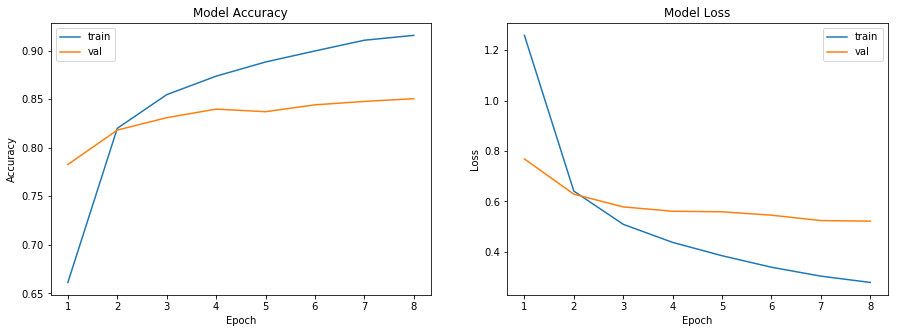

In [20]:
import matplotlib.pyplot as plt

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(model_info)

# Load Test Data

In [21]:
import glob    
import pandas as pd

test_files = glob.glob("./dataset/test/audio/*.wav")
test_filenames = [f.split("/")[-1] for f in test_files]

# Generate Submission

In [23]:
submission = []

possible_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']

num_test = len(test_files)

for i in range(num_test):
    test_wav = mfcc_from_path(test_files[i])[np.newaxis,:,:]
    label = id2name[np.argmax( model.predict(test_wav) )]
    if label not in possible_labels:
        label = 'unknown' 
    submission.append([test_filenames[i], label])
    if i % 3000 == 0:
        print("Predicting {}/{}".format(i, num_test))

print("Finish predicting.....")

submissionDF = pd.DataFrame(submission, columns=['fname','label'])

print("Writing to file.....")
submissionDF.to_csv("submission-lstm-attention.csv", index=False, header=True)

Predicting 0/158538
Predicting 3000/158538
Predicting 6000/158538
Predicting 9000/158538
Predicting 12000/158538
Predicting 15000/158538
Predicting 18000/158538
Predicting 21000/158538
Predicting 24000/158538
Predicting 27000/158538
Predicting 30000/158538
Predicting 33000/158538
Predicting 36000/158538
Predicting 39000/158538
Predicting 42000/158538
Predicting 45000/158538
Predicting 48000/158538
Predicting 51000/158538
Predicting 54000/158538
Predicting 57000/158538
Predicting 60000/158538
Predicting 63000/158538
Predicting 66000/158538
Predicting 69000/158538
Predicting 72000/158538
Predicting 75000/158538
Predicting 78000/158538
Predicting 81000/158538
Predicting 84000/158538
Predicting 87000/158538
Predicting 90000/158538
Predicting 93000/158538
Predicting 96000/158538
Predicting 99000/158538
Predicting 102000/158538
Predicting 105000/158538
Predicting 108000/158538
Predicting 111000/158538
Predicting 114000/158538
Predicting 117000/158538
Predicting 120000/158538
Predicting 12300

In [24]:
import pandas as pd

In [26]:
t = pd.read_csv("submission-lstm-attention.csv",encoding = "utf-8")

In [27]:
t[:10]

,fname,label
0,audio\clip_000044442.wav,down
1,audio\clip_0000adecb.wav,unknown
2,audio\clip_0000d4322.wav,unknown
3,audio\clip_0000fb6fe.wav,unknown
4,audio\clip_0001d1559.wav,unknown
5,audio\clip_0002256ed.wav,unknown
6,audio\clip_0002a4a1f.wav,on
7,audio\clip_0002d9b83.wav,right
8,audio\clip_000373a5b.wav,go
9,audio\clip_0003c7122.wav,unknown


In [30]:
s = t["fname"].apply(lambda x: x.split("\\")[1])

In [32]:
t["fname"] = s

In [33]:
t[:10]

,fname,label
0,clip_000044442.wav,down
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,unknown
3,clip_0000fb6fe.wav,unknown
4,clip_0001d1559.wav,unknown
5,clip_0002256ed.wav,unknown
6,clip_0002a4a1f.wav,on
7,clip_0002d9b83.wav,right
8,clip_000373a5b.wav,go
9,clip_0003c7122.wav,unknown


In [34]:
t.to_csv("submission-lstm-attention.csv", index=False, header=True)